72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/30


C:\Users\azwan\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 - 1s - 23ms/step - accuracy: 0.1962 - loss: 3.7219 - val_accuracy: 0.5764 - val_loss: 1.5159
Epoch 2/30
65/65 - 0s - 3ms/step - accuracy: 0.4201 - loss: 1.9076 - val_accuracy: 0.7511 - val_loss: 1.2042
Epoch 3/30
65/65 - 0s - 3ms/step - accuracy: 0.5406 - loss: 1.5416 - val_accuracy: 0.7904 - val_loss: 0.9944
Epoch 4/30
65/65 - 0s - 3ms/step - accuracy: 0.6348 - loss: 1.3075 - val_accuracy: 0.8472 - val_loss: 0.8561
Epoch 5/30
65/65 - 0s - 3ms/step - accuracy: 0.6707 - loss: 1.1451 - val_accuracy: 0.8472 - val_loss: 0.7493
Epoch 6/30
65/65 - 0s - 3ms/step - accuracy: 0.6945 - loss: 1.0446 - val_accuracy: 0.8734 - val_loss: 0.6711
Epoch 7/30
65/65 - 0s - 3ms/step - accuracy: 0.7164 - loss: 0.9646 - val_accuracy: 0.8690 - val_loss: 0.6151
Epoch 8/30
65/65 - 0s - 3ms/step - accuracy: 0.7348 - loss: 0.9059 - val_accuracy: 0.8777 - val_loss: 0.5722
Epoch 9/30
65/65 - 0s - 3ms/step - accuracy: 0.7610 - loss: 0.8288 - val_accuracy: 0.8865 - val_loss: 0.5396
Epoch 10/30
65/65 - 0s - 3ms/

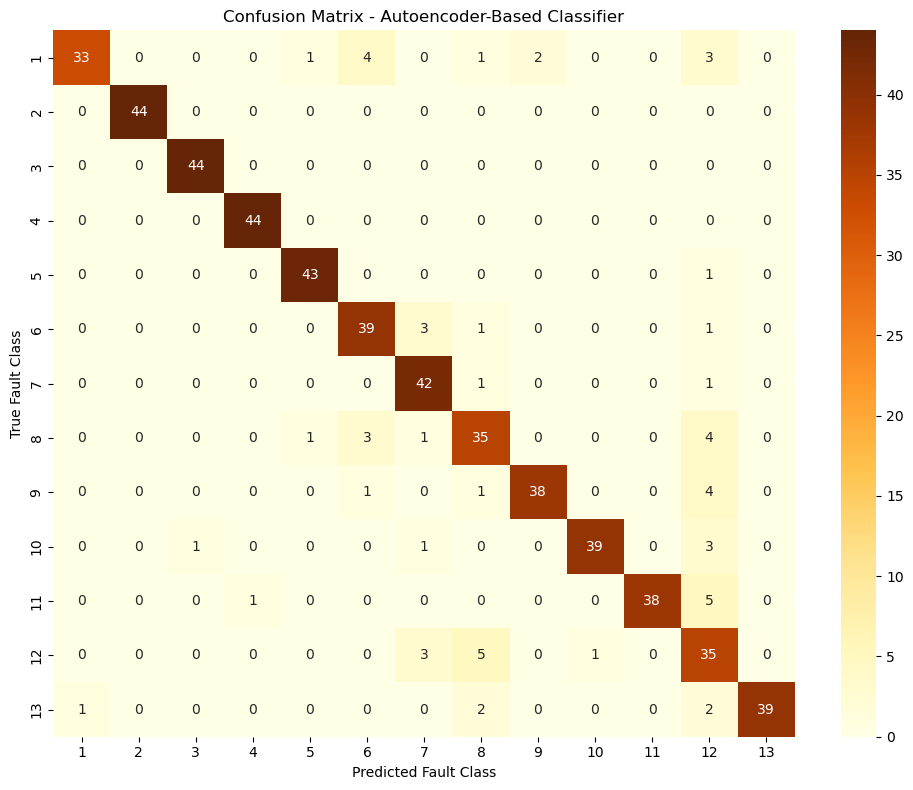

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# 1. Load dataset
df = pd.read_csv('cstr_data.csv')
X = df.iloc[:, :-4].values
y = df.iloc[:, -4].values

# 2. Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Encode labels
num_classes = len(np.unique(y))
y_adjusted = y - 1  # ensure class starts from 0
y_cat = to_categorical(y_adjusted, num_classes)

# 4. Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_cat, test_size=0.2, stratify=y, random_state=42
)

# 5. Define Autoencoder
input_dim = X.shape[1]
encoding_dim = 32

input_layer = Input(shape=(input_dim,))
encoder = Dense(128, activation='relu')(input_layer)
encoder = Dropout(0.3)(encoder)
encoder = Dense(encoding_dim, activation='relu')(encoder)

decoder = Dense(128, activation='relu')(encoder)
decoder = Dropout(0.3)(decoder)
decoder = Dense(input_dim, activation='linear')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.1, verbose=0)

# 6. Extract compressed features (encoder output)
encoder_model = Model(inputs=input_layer, outputs=encoder)
X_train_encoded = encoder_model.predict(X_train)
X_test_encoded = encoder_model.predict(X_test)

# 7. Classifier on top of encoded features
classifier = tf.keras.Sequential([
    Dense(64, activation='relu', input_shape=(encoding_dim,)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 8. Train classifier
classifier.fit(X_train_encoded, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=2)

# 9. Evaluate model
y_pred_probs = classifier.predict(X_test_encoded)
y_pred = np.argmax(y_pred_probs, axis=1) + 1
y_true = np.argmax(y_test, axis=1) + 1
print("Classification Report (AE):\n")
print(classification_report(y_true, y_pred, digits=4))

# 10. Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr', xticklabels=range(1, num_classes+1), yticklabels=range(1, num_classes+1))
plt.xlabel("Predicted Fault Class")
plt.ylabel("True Fault Class")
plt.title("Confusion Matrix - Autoencoder-Based Classifier")
plt.tight_layout()
plt.show()


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Classification Report (Autoencoder Classifier):

              precision    recall  f1-score   support

           0     0.9556    0.9773    0.9663        44
           1     0.9750    0.8864    0.9286        44
           2     1.0000    1.0000    1.0000        44
           3     1.0000    1.0000    1.0000        44
           4     1.0000    1.0000    1.0000        44
           5     1.0000    1.0000    1.0000        44
           6     1.0000    0.9773    0.9885        44
           7     1.0000    1.0000    1.0000        44
           8     0.9302    0.9091    0.9195        44
           9     0.9333    0.9545    0.9438        44
          10     0.9512    0.8864    0.9176        44
          11     0.9286    0.8864    0.9070        44
          12     0.7358    0.8864    0.8041        44

    accuracy                         0.9510       572
   macro avg     0.9546    0.9510    0.9520       572
weighted avg     0.9546    0.9510    0.9520   

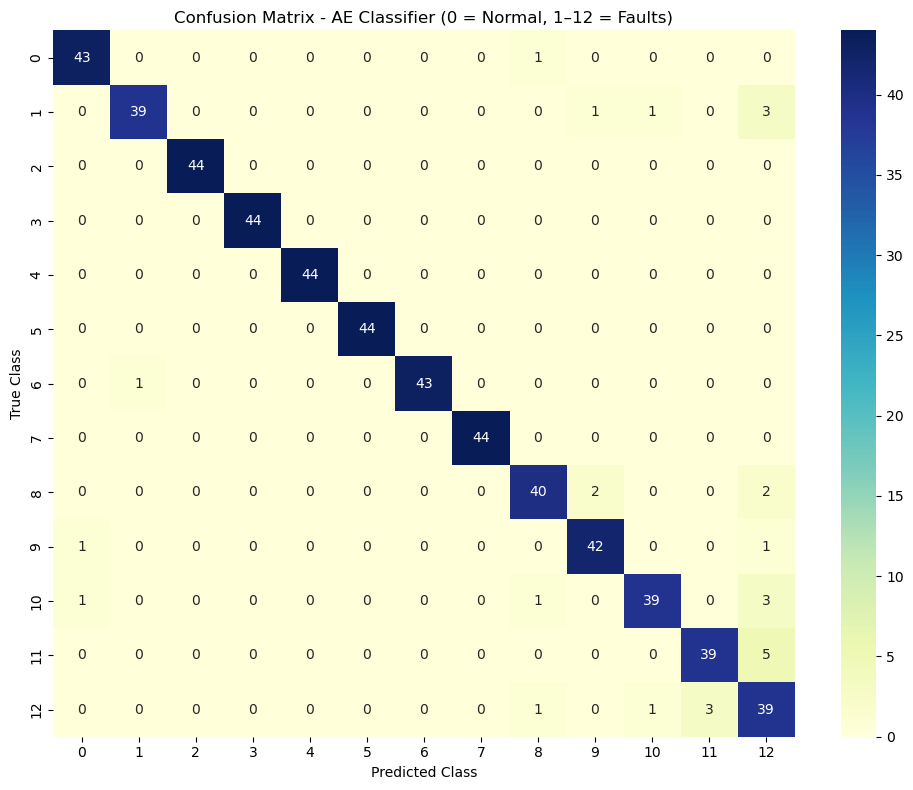

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# 1. Load and preprocess data
df = pd.read_csv('cstr_data.csv')
X = df.iloc[:, :-4]
y = df.iloc[:, -4]  # 0 = normal, 1-12 = fault classes

# 2. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. One-hot encode labels (13 classes: 0 to 12)
num_classes = len(np.unique(y))  # Should be 13
y_cat = to_categorical(y, num_classes)

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_cat, test_size=0.2, stratify=y, random_state=42
)

# 5. Build Autoencoder + Classifier
input_dim = X_train.shape[1]
encoded_dim = 64  # Final encoder output must match classifier input

# Autoencoder encoder
input_layer = Input(shape=(input_dim,))
x = Dense(128, activation='relu')(input_layer)
x = Dense(64, activation='relu')(x)
encoded_output = Dense(encoded_dim, activation='relu')(x)  # output of encoder

# Classifier head
clf = Dense(64, activation='relu')(encoded_output)
clf_output = Dense(num_classes, activation='softmax')(clf)

# Full model
model = Model(inputs=input_layer, outputs=clf_output)
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 6. Train
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.1, verbose=0)

# 7. Predict
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# 8. Report
print("Classification Report (Autoencoder Classifier):\n")
print(classification_report(y_true, y_pred, digits=4))

# 9. Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", 
            xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix - AE Classifier (0 = Normal, 1–12 = Faults)")
plt.tight_layout()
plt.show()
